# Basic Example

This notebook follows the structure discussed in [https://luci-fitting.readthedocs.io/en/latest/example_basic.html](https://luci-fitting.readthedocs.io/en/latest/example_basic.html).

We will go through the steps necessary to use `LUCI`. As you will see, there are only a handful of commands required to use `LUCI`. This example is intentionally loquacious since it is, after all, an example :) 

In order to use `LUCI`, we need to import her, have data available to use, and have an initial guess. We have provided a command below to download a sample data cube (M33 SN3) that can be used to run the examples in this notebook.

#### * If you have not yet downloaded the sample data cube, uncomment the below cell and run and download the sample data cube.  
This will save a file called `M33.hdf5` to the directory where you run this command. Do not be concerned if it takes a few minutes (or more than a few) to download.

In [1]:
# !wget -O M33.hdf5  https://ws.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/raven/files/cadc:CFHT/2309128z.hdf5

Let's start with importing `LUCI`. Just as described on the *readthedocs* page, we need to point our system path to our install location of the **`LUCI`** folder. 

We assume that the main project directory is the parent of the current Notebooks directory. For example, **`LUCI`**'s main directory lives in `/home/jessie/repos/LUCI` and my current directory is `/home/jessie/repos/LUCI/Examples`

However, we also provde instructions for how to point to the proper path if your main project directory is in a different directory. In this example, the data directory is `/home/carterrhea/Docments/M33`.

In [2]:
# Imports
import os
import sys

import numpy as np
import matplotlib.pyplot as plt

# Get location of LUCI 
path = os.path.abspath(os.path.pardir)  
sys.path.insert(0, path)  # add LUCI to the available paths

from LuciBase import Luci
import LUCI.LuciPlotting as lplt

%config Completer.use_jedi=False  # enable autocompletion when typing in Jupyter notebooks

2024-05-08 16:14:42.946750: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-08 16:14:43.139731: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/src/heasoft-6.31.1/x86_64-pc-linux-gnu-libc2.35/lib
2024-05-08 16:14:43.139756: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-05-08 16:14:45.027560: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror:

Set the required parameters. We will be using our machine learning algorithm to get the initial guesses - this happens under the hood in `LuciFit`, so that the user is not required to think about the initial guess

In [3]:
# Initialize paths and set parameters
Luci_path = '/home/carterrhea/Documents/LUCI/'
cube_dir = '/export/home/carterrhea/M33'  # Path to data cube
cube_name = 'M33_SN3'  # don't add .hdf5 extension
object_name = 'M33'
filter_name = 'SN3'
redshift = -0.0006  # Redshift of object
resolution = 5000

Intialize our LUCI object

In [4]:
cube = Luci(Luci_path, cube_dir + '/' + cube_name, cube_dir, object_name, redshift, resolution)

Reading in data...


100%|█████████████████████████████████████████████| 9/9 [00:34<00:00,  3.80s/it]


Create a deep frame

In [5]:
cube.create_deep_image()

Existing deep frame extracted from hdf5 file.


Let's extract a background region and take a look at it. The background region is defined in a ds9 region file in the `Examples/regions` folder in the LUCI directory.

100%|█████████████████████████████████████| 2064/2064 [00:00<00:00, 3846.49it/s]


<AxesSubplot:xlabel='Wavelength [cm-1]', ylabel='Flux [ergs s$^{-1}$ cm$^{-2}$ $\\AA^{-1}$]'>

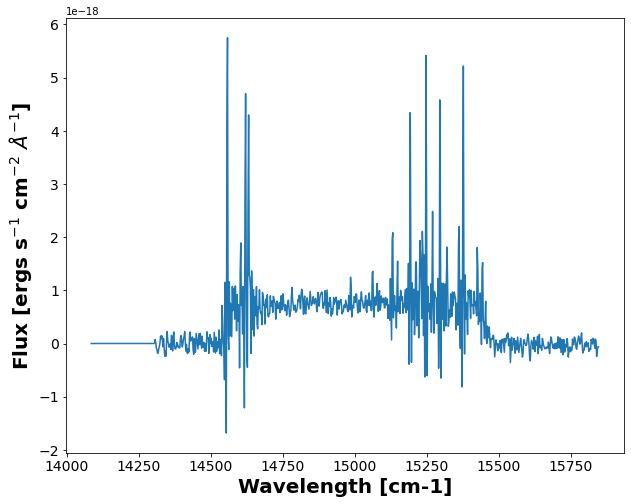

In [6]:
# We use 'mean = True' to take the mean of the emission in the region instead of the sum
bkg_axis, bkg_sky = cube.extract_spectrum_region(Luci_path+'Examples/regions/bkg_M33.reg', mean=True)
lplt.plot_spectrum(bkg_axis, bkg_sky)

We now fit part of our cube defined by the bounding box `1200 < x < 1350` and `1700 < y < 1950` with a SincGauss on the Halpha line, the NII-doublet, and the SII-doublet with a binning of 2. We will also tie all of our parameters together. 

For this example, we do not calculate the errors because it slows down calculations, but note that it can easily be done by adding the argument `uncertainty_bool=True`. If you want the full Bayesian calculation you can add `bayes_bool=True`.

In [8]:
# Fit!
vel_map, broad_map, flux_map, ampls_map = cube.fit_cube(
    ['Halpha', 'NII6548', 'NII6583', 'SII6716', 'SII6731'],  # lines
    'sincgauss',   # fit function
    [1,1,1,1,1],  # velocity relationship 
    [1,1,1,1,1],  # sigma relationship
    1200, 1350,    # x bounds
    1700, 1950,    # y bounds
    bkg=bkg_sky, 
    binning=2,  
    n_threads=20
)


 16%|██████▋                                   | 20/125 [00:06<00:34,  3.01it/s]WARNING:tensorflow:From /home/carterrhea/anaconda3/envs/luci/lib/python3.9/site-packages/tensorflow/python/util/deprecation.py:561: calling function (from tensorflow.python.eager.polymorphic_function.polymorphic_function) with experimental_relax_shapes is deprecated and will be removed in a future version.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
ex

Let's take a look at the flux map for Halpha. 

** Note that if the user enters 'flux' then the plotting method automatically takes the log base 10 and plots that. The flux is generally easier to visualize in log space.

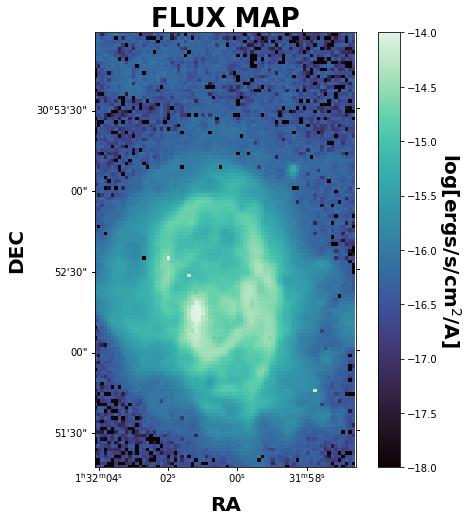

In [9]:
lplt.plot_map(flux_map[:,:,0], 'flux', object_name=object_name, filter_name=filter_name, output_dir=cube_dir, header=cube.header, clims=[-18, -14])

Let's also take a look at the velocity and broadening maps.

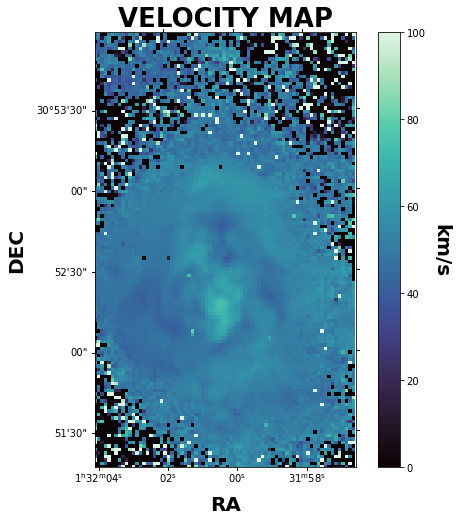

In [11]:
lplt.plot_map(vel_map[:,:,0], 'velocity', object_name=object_name, filter_name=filter_name, output_dir=cube_dir, header=cube.header, clims=[0, 100])

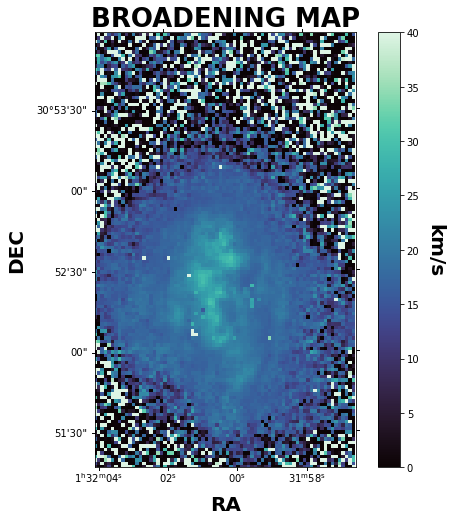

In [12]:
lplt.plot_map(broad_map[:,:,0], 'broadening', object_name=object_name, filter_name=filter_name, output_dir=cube_dir, header=cube.header, clims=[0, 40])

And that is it! Congratulations, you have just used `LUCI`! 